# Singular Spectrum Analysis (SSA) on drifter trajectory time series

**Big picture:**

*Are neural networks actually useful? Do they offer any advantage over existing mathematical prediction techniques or human pattern recognition?*

For example: A human with 10+ years of intellectualy training can watch a drifter move for a few hours/days and predict was certain accuracy that it will spiral as it is carried by some background flow. Can a neural network learn the same thing, thereby eliminating the need for human training and brainpower?

In this example, the human is quickly observing dominant flow patterns, such as the mean background flow combined with inertial oscillations. Thus, the first step toward determining whether a neural network can learn these patterns is to identify mathematically or statistically identify them.

Singular spectrum analysis (SSA) can be used for this. Like with PCA/POD/EOF, SSA uses singular value decomposition (SVD) to decompose a time series into dominant patterns by projecting the time series matrix onto new orthonormal bases. Once complete, the original time series can be obtained by summing over all elementary components. (Or, alternatively, noise can be filtered out by summing over some *k* components.)

The goal is to decompose 3-4 days worth of drifter data from the GLAD S1 deployment and identify the dominant patterns. Hopefully the patterns are consistent between drifters. Separate neural networks can be trained to learn each pattern such that the predicted drifter trajectory would be obtained by summing the output time series from all of these networks.

This should provide better insight into whether the neural network from the last paper is actually learning signal or just guessing future points.

**To implement:**

- Automated method of grouping elementary components into unique patterns: unsupervised classification problem with unknown number of groups/patterns

***

In [1]:
# Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# My modules
import ssa
import trajectories as traj

In [2]:
# Fiddle with figure settings here:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=''):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [3]:
def data_readIn(file, dates=('2012-07-22', '2012-07-31')):
    x = pd.read_csv(file, delimiter='\t', index_col='datetime',
                    parse_dates=True)
    return x.loc[dates[0]:dates[1], x.columns.astype('int').isin(lg.index)]\
            .dropna(how='all', axis=0)

In [4]:
def normalize(x, index=0):
    """Normalize to interval [0,1]."""
    mins = x.min().min()
    maxs = x.max().max()
    return (x - mins) / (maxs - mins)

In [5]:
def unnormalize(x, mins, maxs):
    """Un-normalize x using mins and maxs."""
    return (x * (maxs - mins)) + mins

In [6]:
def format_tseries(x, n_days):
    """Format time series for SSA: extract desired length and remove leading NAs"""
    x.dropna(inplace=True)
    return x.loc[x.index[1]:(x.index[0]+pd.Timedelta(days=n_days))]

In [7]:
def perform_ssa(m=None, rm_mean=False, norm=True, silent=False):
    # Make time series
    u_ts = format_tseries(u.loc[:,drifter], n_days=n_days)
    v_ts = format_tseries(v.loc[:,drifter], n_days=n_days)
    
    # Subtract mean (optional)
    if rm_mean:
        u_ts = u_ts - u_ts.mean()
        v_ts = v_ts - v_ts.mean()
    
    # Normalize (optional)
    if norm:
        u_ts = normalize(u_ts)
        v_ts = normalize(v_ts)
    
    # Decompose
    if not m:
        m = (uParams.loc[drifter, 'm'], vParams.loc[drifter, 'm'])
    elif isinstance(m, int):
        m = (m, m)
    ussa = ssa.SSA(tseries=u_ts, window=m[0])
    vssa = ssa.SSA(tseries=v_ts, window=m[1])
    if not silent:
        print('Performing SSA on drifter ID {} with window of size {} lags for u '\
              'and size {} lags for v (of max {}).'\
              .format(drifter, m[0], m[1], len(u_ts)//2))
    return (ussa, vssa)

In [8]:
def reconstruct(k=None, add_mean=False, norm=True, silent=False):
    # Reconstruct velocity time series
    if k is None:
        k = (slice(0, uParams.loc[drifter,'k']), 
             slice(0, vParams.loc[drifter,'k']))
    elif isinstance(k, (slice, int)):
        k = (k, k)
    if norm:
        u_reconst = unnormalize(ussa.reconstruct(k[0]),
                                mins=u.min().min(), maxs=u.max().max())
        v_reconst = unnormalize(vssa.reconstruct(k[1]),
                                mins=v.min().min(), maxs=v.max().max())
    else:
        u_reconst = ussa.reconstruct(k[0])
        v_reconst = vssa.reconstruct(k[1])
    
    # Add mean (optional: use if rm_mean=True in perform_ssa())
    if add_mean:
        umean = format_tseries(u.loc[:,drifter], n_days=n_days).mean()
        vmean = format_tseries(v.loc[:,drifter], n_days=n_days).mean()
        u_reconst = u_reconst + umean
        v_reconst = v_reconst + vmean
        
    if not silent:
        print('Optimum reconstruction using {} elementary components for u '\
              'and {} elementary components for v.'.format(k[0], k[1]))
    
    # Calculate trajectory
    initial_lat = lat.loc[:,drifter].dropna()[1]
    initial_lon = lon.loc[:,drifter].dropna()[1]
    delta_t = u_reconst.index.to_series().diff()[-1].total_seconds()
    lats, lons = traj.calc_geotraj(lat0=lat.loc[:,drifter].dropna()[1],
                                   lon0=lon.loc[:,drifter].dropna()[1],
                                   u=u_reconst, v=v_reconst, dt=delta_t)

    # Concatenate results
    reconst = pd.concat([u_reconst, v_reconst,
                         pd.Series(lons, index=u_reconst.index),
                         pd.Series(lats, index=v_reconst.index)], axis=1)
    reconst.columns = ['u','v','lon','lat']
    return reconst

In [9]:
def find_patterns(s):
    """
    Group SSA elementary components by correlation to identify prominant 
    patterns of variability in time series.
    """
    # Signal-noise splitting index
    sn_ind = sum(s.get_variance() <= 0.9)-1
    # Upper triangular correlation matrix
    tri = s.get_wcorr()[0:sn_ind, 0:sn_ind] * \
          np.tri(*s.get_wcorr()[0:sn_ind,0:sn_ind].shape).T
    # Group SSA elementary components by correlation
    pairings = np.argwhere((tri>0.09) & (tri!=1))
    weights = tri[(tri>0.09) & (tri!=1)]
    # Generate patterns
    patterns = ssa.group(pairs=pairings, corr=weights)
    # Return results
    return [s.get_window(), len(s.get_original()), s.K, sn_ind, len(patterns)]

In [10]:
def plotting():
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.plot(lon.loc[reconstructed.index, drifter][1:],
            lat.loc[reconstructed.index, drifter][1:], label='Observed')
    ax.plot(reconstructed.lon, reconstructed.lat,
            linestyle='dashed', label='Reconstructed')
    ax.scatter(reconstructed.lon[0], reconstructed.lat[0], color='black')
    ax.legend(loc='best')
    plt.show()

***

Read in GLAD S1 log file for selecting relevant drifter IDs

In [11]:
lg = pd.read_csv('../data/spot_drifter_deployment_log_S1.csv', skiprows=[1])
lg.dropna(how='all', inplace=True)
lg['SPOT ID'] = lg['SPOT ID'].astype(int)
lg['time'] = pd.to_datetime(lg['Date'] + ' ' + lg['Time (UTC)'])
lg = lg.iloc[:,[1,2,3,4,-1]]
lg.set_index('SPOT ID', inplace=True)

Read in GLAD drifter data

In [12]:
u = data_readIn('../data/GLAD_u.csv', dates=('2012-07-22', '2012-07-31'))
v = data_readIn('../data/GLAD_v.csv', dates=('2012-07-22', '2012-07-31'))
lat = data_readIn('../data/GLAD_lat.csv', dates=('2012-07-22', '2012-07-31'))
lon = data_readIn('../data/GLAD_lon.csv', dates=('2012-07-22', '2012-07-31'))

***

Read in SSA parameter search results

In [9]:
uParams = pd.read_csv('../results/ssa/u_3day_bestParams.csv',
                      index_col='drifterID', dtype={'drifterID':'string'})
vParams = pd.read_csv('../results/ssa/v_3day_bestParams.csv',
                      index_col='drifterID', dtype={'drifterID':'string'})

In [10]:
print('Value counts of parameter m for u:')
print(uParams.m.value_counts())
print('and for v:')
print(vParams.m.value_counts())

Value counts of parameter m for u:
4    65
3    24
Name: m, dtype: int64
and for v:
3    88
2     1
Name: m, dtype: int64


In [11]:
print('Value counts of parameter k for u:')
print(uParams.k.value_counts())
print('and for v:')
print(vParams.k.value_counts())

Value counts of parameter k for u:
1    89
Name: k, dtype: int64
and for v:
1    89
Name: k, dtype: int64


***

# Testing and plotting trajectories

**Drifter time series to analyze**

In [30]:
drifter = u.columns[5]
norm = True
n_days = 3

ussa, vssa = perform_ssa(m=int(0.35 * 4*24 * n_days), norm=norm)

Performing SSA on drifter ID 26 with window of size 100 lags for u and size 100 lags for v (of max 144).


In [31]:
# Range of acceptable m's
#m_range = np.log(len(ussa.get_original()))**[1.5, 3.0]
#print(np.arange(np.ceil(m_range[0]), np.floor(m_range[1]), dtype=int))

Optimum reconstruction uses 1 elementary components for u and 1 elementary components for v.


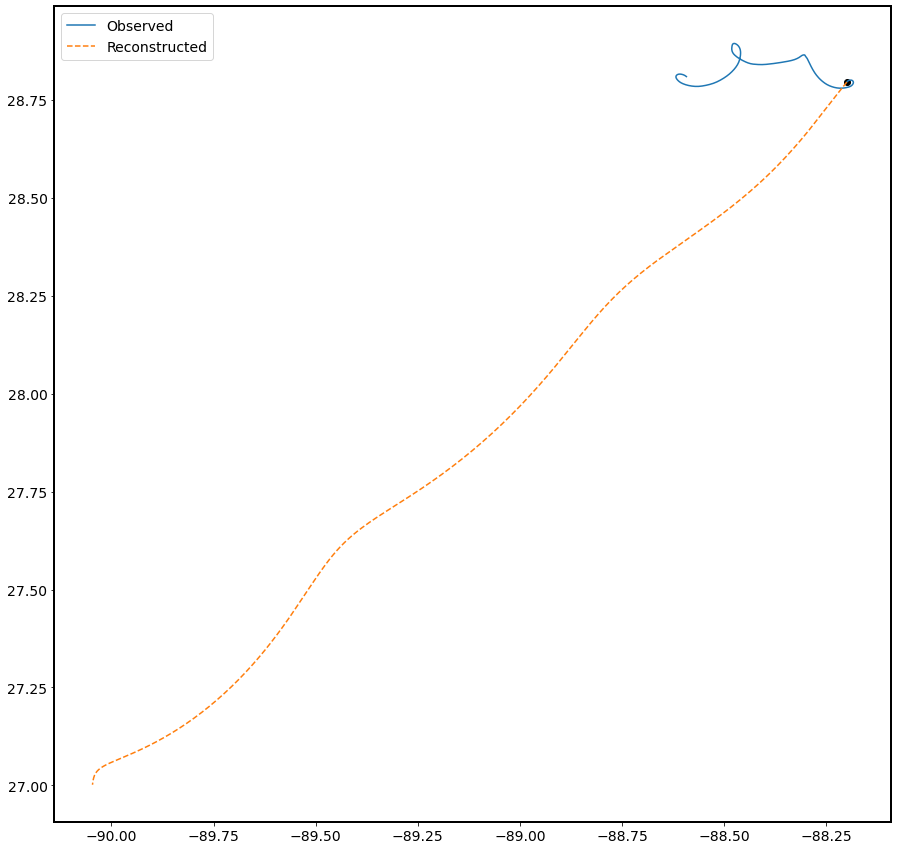

In [32]:
reconstructed = reconstruct(1, norm=norm)
plotting()

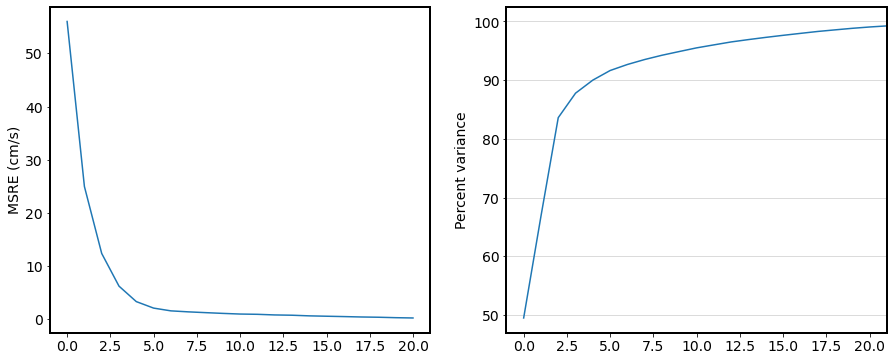

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot([np.sqrt(ussa.calc_msre(slice(0,i)))*100 for i in range(21)])
ax1.set_ylabel('MSRE (cm/s)')
ax1.set_xlim(-1, 21)
ax2.plot(ussa.get_variance()*100)
ax2.set_ylabel('Percent variance')
ax2.set_xlim(-1, 21)
ax2.grid(b=True, which='major', axis='y', color='lightgrey')
plt.show()

In [34]:
# for i in range(21):

#     reconstructed = reconstruct(slice(0,i), silent=True)

#     fig, ax = plt.subplots(1, 1, figsize=(15,15))
#     ax.plot(lon.loc[reconstructed.index, drifter][1:],
#             lat.loc[reconstructed.index, drifter][1:],
#             label='Observed')
#     ax.plot(reconstructed.lon, reconstructed.lat,
#             linestyle='dashed', label='Reconstructed')
#     ax.scatter(reconstructed.lon[0], reconstructed.lat[0], color='black')
#     ax.set_title('Elementary component {}'.format(i))
#     ax.set_ylim(28.625, 28.855)
#     ax.set_xlim(-88.36, -88.10)
#     ax.set_ylabel('Latitude')
#     ax.set_xlabel('Longitude')
#     plt.legend(loc='upper left')
#     fig.savefig('../results/ssa/plots/u_reconstruction_{}.png'.format(str(i).zfill(2)),
#                dpi=100, bbox_inches='tight')
#     plt.close('all')

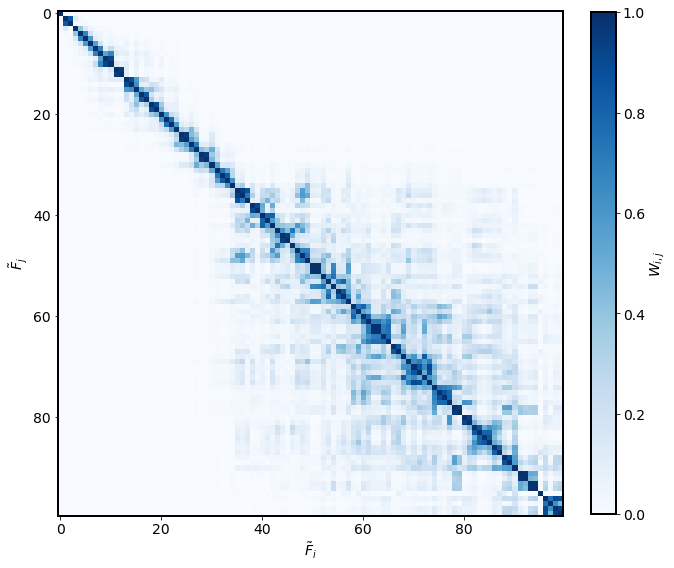

In [35]:
ussa.plot_wcorr()

Separate signal from noise

In [36]:
#sn_ind = ssa.signal_noise_split(ussa.get_wcorr(), method='pdf', var_thresh=2e-3)
#sn_ind = ssa.signal_noise_split(ussa.get_wcorr(), method='counts', cor_thresh=1.0e-2)
sn_ind = sum(ussa.get_variance() <= 0.95)

In [37]:
ussa.get_variance()[:sn_ind]

array([0.49522117, 0.66845187, 0.83627353, 0.87792419, 0.9001657 ,
       0.91649203, 0.92677491, 0.93522423, 0.94250301, 0.94883287])

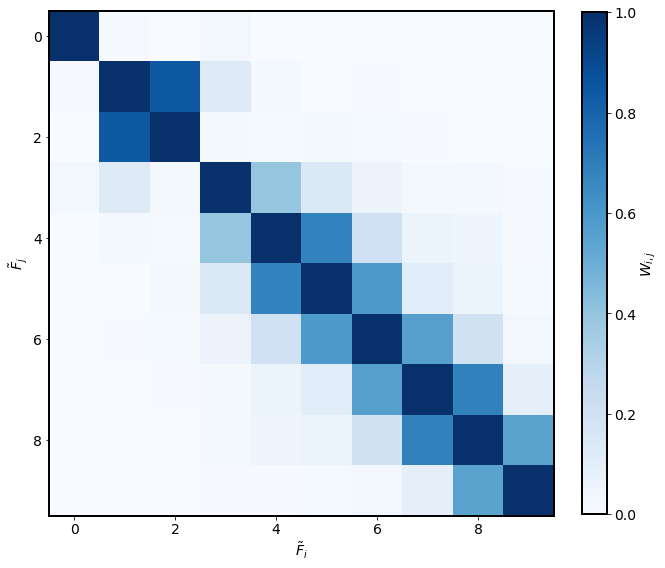

In [38]:
ussa.plot_wcorr(max=sn_ind-1)

In [39]:
tri = ussa.get_wcorr()[0:sn_ind, 0:sn_ind] * np.tri(*ussa.get_wcorr()[0:sn_ind,0:sn_ind].shape).T

Group elementary nodes by weighted correlation to generate dictionary of patterns

In [40]:
pairings = np.argwhere((tri>0.09) & (tri!=1))
weights = tri[(tri>0.09) & (tri!=1)]

In [41]:
# Unormalized
# patterns = ssa.group(pairings, weights)
# patterns

In [42]:
patterns = ssa.group(pairings, weights)
patterns

{'F00': (1, 2), 'F01': (4, 5, 6, 3), 'F02': (7, 8, 9), 'F03': (0,)}

In [45]:
ussa.find_patterns(0.95)
ussa.get_patterns()

{'F00': (1, 2), 'F01': (4, 5, 6, 3), 'F02': (7, 8, 9), 'F03': (0,)}

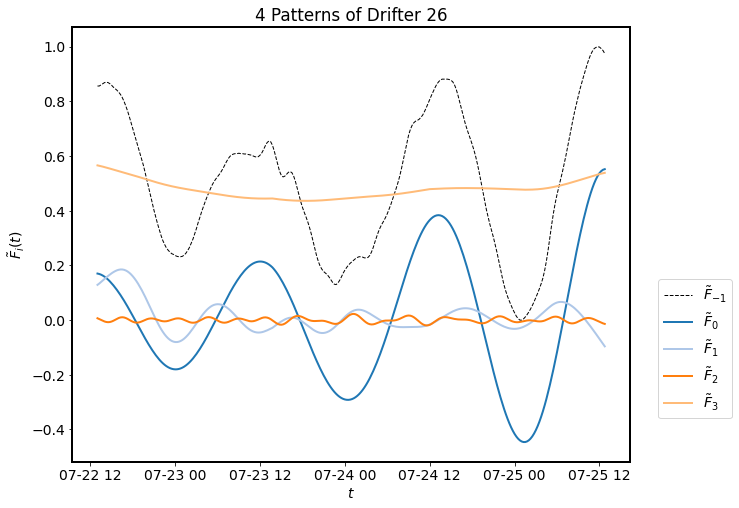

In [46]:
# Fiddle with colour cycle - need more colors!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
fig.axes.plot(ussa.get_original(), alpha=1, lw=1, color='black', linestyle='dashed', zorder=0)
for key in patterns.keys():
    fig.axes.plot(ussa.reconstruct(patterns[key]), lw=2, zorder=1)

fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %(i-1) for i in range(sn_ind)] + ["$F$"]
fig.set_title("{} Patterns of Drifter {}".format(len(patterns), drifter))
fig.legend(legend, loc=(1.05,0.1));

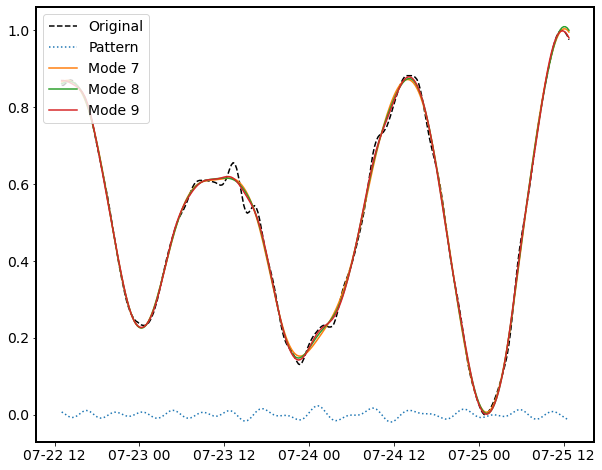

In [49]:
fig, ax = plt.subplots(1, 1)
ax.plot(ussa.get_original(), color='black', linestyle='dashed', zorder=0, label='Original')
ax.plot(ussa.reconstruct(patterns['F02']), label='Pattern', linestyle='dotted')
for v in patterns['F02']:
    ax.plot(ussa.reconstruct(slice(v)), label='Mode {}'.format(v), zorder=1)
plt.legend(loc='upper left')
plt.show()

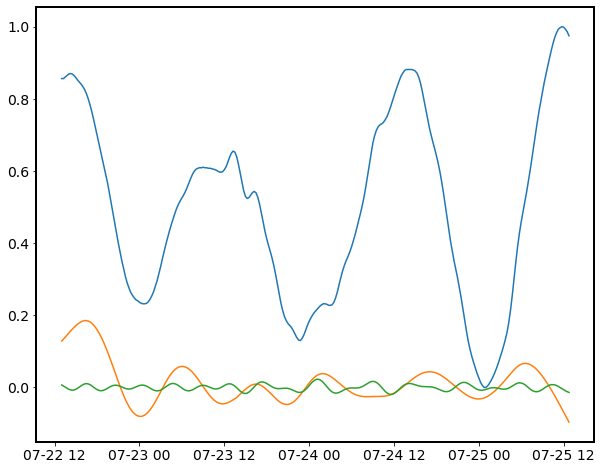

In [48]:
fig, ax = plt.subplots(1, 1)
ax.plot(ussa.get_original())
ax.plot(ussa.reconstruct(patterns['F01']))
ax.plot(ussa.reconstruct(patterns['F02']))
plt.show()

Compile into dataframe

In [26]:
df = pd.DataFrame(index=u.columns, columns=['LagWindow', 'TSeriesLen', 'TrajMatLen', 'SignalComponents', 'Patterns'])

In [27]:
df.loc[drifter] = [ussa.get_window(), len(ussa.get_original()), ussa.K, sn_ind, len(patterns)]

***

# SSA Reconstruction Results

**3-day decomposition**

In [149]:
u_summary = pd.read_csv('../results/ssa/u_pattern_search_3day.csv', index_col=0)
v_summary = pd.read_csv('../results/ssa/v_pattern_search_3day.csv', index_col=0)

In [150]:
print(u_summary.Patterns.value_counts())

4    42
5    32
3    10
6     4
7     1
Name: Patterns, dtype: int64


In [151]:
v_summary.Patterns.value_counts()

5    41
4    35
6     6
3     6
7     1
Name: Patterns, dtype: int64

In [152]:
u_summary.SignalComponents.value_counts()

8     25
9     23
11    15
10     9
12     7
7      7
15     1
14     1
6      1
Name: SignalComponents, dtype: int64

In [153]:
v_summary.SignalComponents.value_counts()

9     29
10    23
8     20
12     6
11     6
7      3
15     1
6      1
Name: SignalComponents, dtype: int64

**4-day decomposition**

In [154]:
u_summary = pd.read_csv('../results/ssa/u_pattern_search_4day.csv', index_col=0)
v_summary = pd.read_csv('../results/ssa/v_pattern_search_4day.csv', index_col=0)

In [155]:
u_summary.Patterns.value_counts()

5    39
6    36
7     7
4     6
8     1
Name: Patterns, dtype: int64

In [156]:
v_summary.Patterns.value_counts()

6    41
5    37
7     5
4     5
8     1
Name: Patterns, dtype: int64

In [157]:
u_summary.SignalComponents.value_counts()

12    31
13    17
11    14
14    13
10     7
17     2
16     2
15     2
18     1
Name: SignalComponents, dtype: int64

In [158]:
v_summary.SignalComponents.value_counts()

13    29
12    21
14    16
11    11
15     9
20     1
16     1
9      1
Name: SignalComponents, dtype: int64

Notes from Aksamit paper:
- LSTM instead of 'simple' ANN
- Train NN(s) to learn patterns (e.g., F0-Fn) and then a separate 'corrective' NN to learn the error, as in the paper?
- Considered LASER, GLAD, and both together, for predictive time scales O(month) (50 days)
- Input: drifter velocity, drifter acceleration, and wind speed

***

**Removing mean before performing SSA**

In [179]:
drifter = u.columns[20]
n_days = 3
ussa, vssa = perform_ssa(m=int(0.5*96*3), rm_mean=True)

Performing SSA on drifter ID 41 with window of size 144 lags for u and size 144 lags for v (of max 144).


In [151]:
ussa.get_variance()

array([0.31809904, 0.61447901, 0.65787296, 0.69791196, 0.73398067,
       0.76743218, 0.78660534, 0.8054895 , 0.82312196, 0.83885712,
       0.85191954, 0.86427565, 0.87599611, 0.8858382 , 0.8955994 ,
       0.9043918 , 0.91317598, 0.92169215, 0.93012953, 0.93705176,
       0.94301982, 0.94838638, 0.95369966, 0.95820639, 0.96267868,
       0.96679736, 0.97090869, 0.97460495, 0.9781737 , 0.98109706,
       0.98361561, 0.98549444, 0.98725873, 0.98876701, 0.98993615,
       0.99084044, 0.99169481, 0.992321  , 0.99292865, 0.99346432,
       0.99392936, 0.99417511, 0.99440589, 0.99457128, 0.9946996 ,
       0.99481711, 0.99493404, 0.9950391 , 0.99514358, 0.99524579,
       0.99534674, 0.99544559, 0.99554173, 0.99563698, 0.99573077,
       0.99582339, 0.99591491, 0.99600351, 0.99609201, 0.99617973,
       0.99626715, 0.99635341, 0.99643809, 0.99652173, 0.99660525,
       0.99668865, 0.99676954, 0.9968504 , 0.99692712, 0.99700198,
       0.99707649, 0.99714993, 0.99722325, 0.9972964 , 0.99736

Optimum reconstruction uses 1 elementary components for u and 1 elementary components for v.


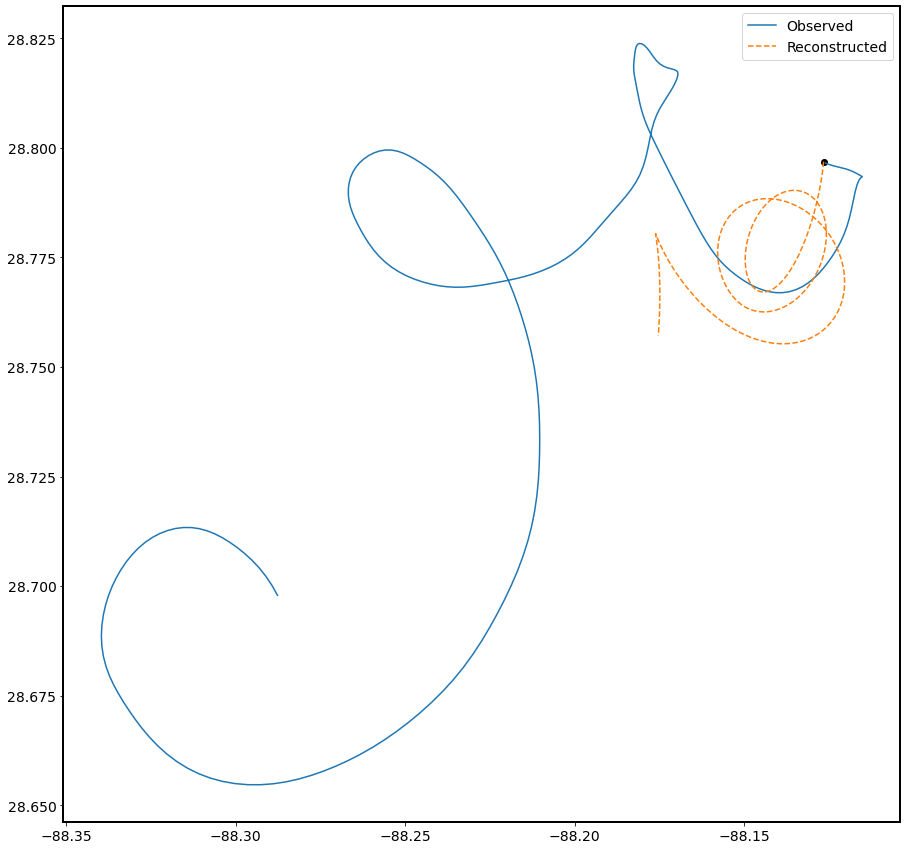

In [183]:
reconstructed = reconstruct(1, add_mean=False)
plotting()

***

# Find optimum m, k values

***This was run first to determine optimum m, k parameters***

Cutoff threshold (fraction) for reconstruction $\in (0,1]$

In [6]:
threshold = 0.95

Length of time series (days) (should be >= 1)

In [7]:
n_days = 3

Parameter range checks

In [8]:
assert n_days >=1, 'Time series must be at least one day long.'
assert 0 < threshold and threshold <= 1, 'Threshold must be in the interval (0,1].'

Generate list of *m* lag window values based on number of observations in one day

In [9]:
obsPerDay = u.reset_index()['datetime'].dt.day.value_counts().iloc[0]
m_list = np.arange(2, (obsPerDay*n_days)/2+1, dtype=int)
print('Testing m from {} to {}'.format(m_list.min(), m_list.max()))

Testing m from 2 to 144


Loop through drifters: *u*

In [45]:
uresults = {}

start_time = time.time()
for drifter in u.columns:
    u_ts = format_tseries(u.loc[:,drifter], n_days=n_days)
    uresults[drifter] = ssa.mtest(tseries=u_ts, m_list=m_list, k_thresh=threshold)
end_time = time.time()

print('SSA parameter test runtime: {} min'.format(round((end_time - start_time)/60, 1)))

SSA parameter test runtime: 29.1 min


Remove time series and write to file

In [29]:
uresults2 = copy.deepcopy(uresults)
for keys, values in uresults2.items():
    del uresults2[keys]['TimeSeries']

pd.DataFrame.from_dict(uresults2, orient='index').rename_axis('drifterID')\
            .to_csv('../results/ssa/u_3day_bestParams.csv')

Repeat for v

In [43]:
vresults = {}

start_time = time.time()
for drifter in v.columns:
    v_ts = format_tseries(v.loc[:,drifter], n_days=n_days)
    vresults[drifter] = ssa.mtest(tseries=v_ts, m_list=m_list, k_thresh=threshold)
end_time = time.time()

print('SSA parameter test runtime: {} min'.format(round((end_time - start_time)/60, 1)))

SSA parameter test runtime: 29.0 min


Remove time series and write to file

In [44]:
vresults2 = copy.deepcopy(vresults)
for keys, values in vresults2.items():
    del vresults2[keys]['TimeSeries']

pd.DataFrame.from_dict(vresults2, orient='index').rename_axis('drifterID')\
            .to_csv('../results/ssa/v_3day_bestParams.csv')

***

In [229]:
drifter = u.columns[60]
n_days = 3

In [230]:
# Perform SSA
u_ts = format_tseries(u.loc[:,drifter], n_days=n_days)
v_ts = format_tseries(v.loc[:,drifter], n_days=n_days)
ussa = ssa.SSA(tseries=u_ts, window=uresults[drifter]['m'])
vssa = ssa.SSA(tseries=v_ts, window=vresults[drifter]['m'])
print('Performing SSA using window of size {} lags for u '\
      'and size {} for v'\
      .format(results[drifter]['m'], results[drifter]['m']))

# Initial conditions for trajectories
initial_lat = lat.loc[:,drifter].dropna()[1]
initial_lon = lon.loc[:,drifter].dropna()[1]
delta_t = u_reconst.index.to_series().diff()[-1].total_seconds()

Performing SSA using window of size 4 lags for u and size 4 for v


In [231]:
# Reconstruct velocities
# u_reconst = ussa.reconstruct(slice(0,None))
# v_reconst = vssa.reconstruct(slice(0,None))
u_reconst = ussa.reconstruct(slice(0,uresults[drifter]['k']))
v_reconst = vssa.reconstruct(slice(0,vresults[drifter]['k']))
print('Optimum reconstruction uses {} elementary components for u '\
      'and {} elementary components for v.'\
      .format(uresults[drifter]['k'], vresults[drifter]['k']))

# Calculate trajectory
lats, lons = traj.calc_geotraj(lat0=lat.loc[:,drifter].dropna()[1],
                               lon0=lon.loc[:,drifter].dropna()[1],
                               u=u_reconst, v=v_reconst, dt=delta_t)

Optimum reconstruction uses 1 elementary components for u and 1 elementary components for v.


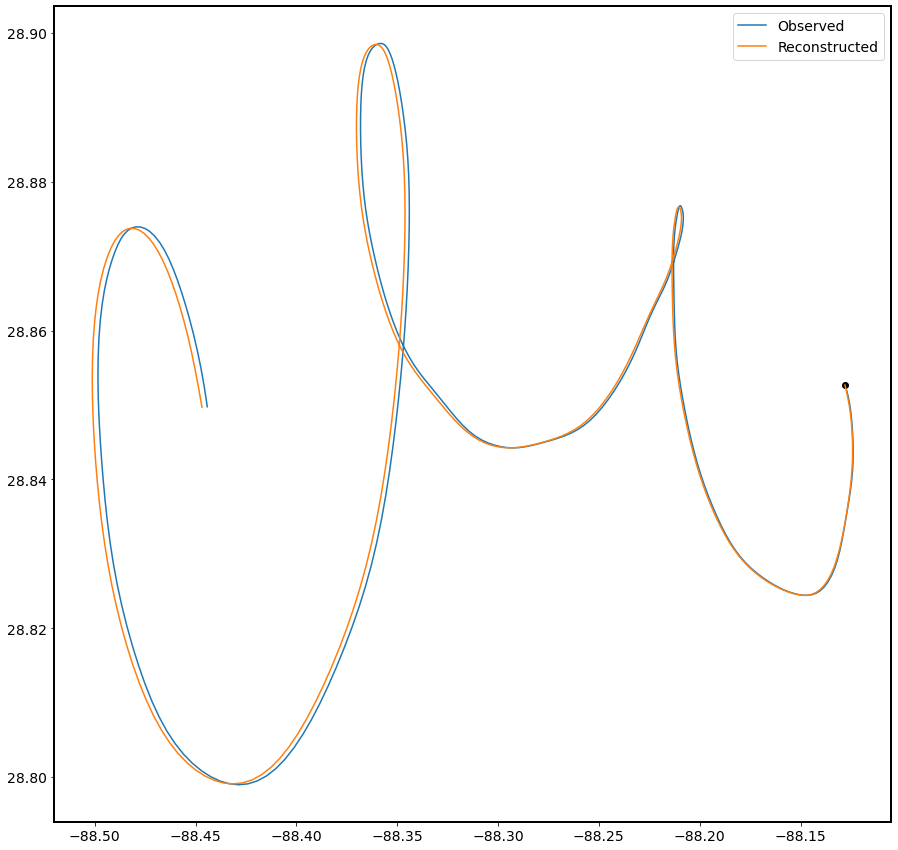

In [232]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.plot(lon.loc[u_reconst.index,drifter][1:],
        lat.loc[v_reconst.index,drifter][1:], label='Observed')
ax.plot(lons, lats, label='Reconstructed')
ax.scatter(initial_lon, initial_lat, color='black')
ax.legend(loc='best')
ax.plot()
plt.show()